<a href="https://colab.research.google.com/github/sayevvv/PCVK_2025/blob/main/PCVK_modul7_Abdulllah_Shamil_Basayev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODUL 7 – Filter Spasial Low Pass Filter, High Pass Filter, Point Detection, Line Detection, Edge Detection

#Cell 1 – Mount Drive dan Path Gambar

In [1]:
# Mount Google Drive dan siapkan path gambar "kitten"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob

# Path yang kamu minta (tanpa slash depan), dan fallback dengan slash
USER_PATH = "content/drive/MyDrive/image/kitten"
CANDIDATES = [
    USER_PATH,
    "/" + USER_PATH.lstrip("/"),
    "/content/drive/MyDrive/PCVK/Images/kitten",
]

# Jika user tidak menuliskan ekstensi, coba beberapa ekstensi umum
EXTS = ["", ".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"]

def resolve_image_path():
    # 1) coba exact match kandidat + ekstensi
    for base in CANDIDATES:
        for ext in EXTS:
            p = base if base.lower().endswith(tuple([e for e in EXTS if e])) else base + ext
            if os.path.exists(p):
                return p
    # 2) kalau base adalah folder, cari file pertama di dalamnya
    for base in CANDIDATES:
        if os.path.isdir(base):
            files = []
            for ext in EXTS[1:]:
                files.extend(glob.glob(os.path.join(base, f"*{ext}")))
            if files:
                return files[0]
    raise FileNotFoundError("Gambar 'kitten' tidak ditemukan. Periksa path/ekstensi.")

IMG_PATH = resolve_image_path()
IMG_PATH

Mounted at /content/drive


'/content/drive/MyDrive/PCVK/Images/kitten.jpg'

#Cell 2 – Import Library dan Fungsi Dasar

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Tidak bisa membaca gambar: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def to_gray(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def show_side_by_side(imgs, titles=None, cmap='gray', figsize=(15,5)):
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs, 1):
        plt.subplot(1, len(imgs), i)
        if im.ndim == 2:
            plt.imshow(im, cmap=cmap)
        else:
            plt.imshow(im)
        if titles:
            plt.title(titles[i-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


#Cell 3 – Baca dan Tampilkan Gambar

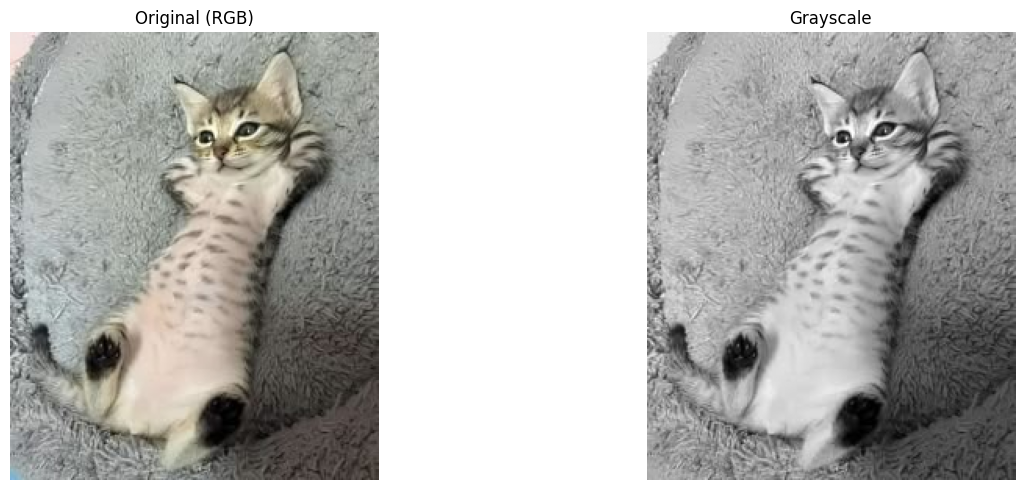

In [3]:
img_rgb = imread_rgb(IMG_PATH)
img_gray = to_gray(img_rgb)

show_side_by_side([img_rgb, img_gray], ["Original (RGB)", "Grayscale"])


#Cell 4 – Fungsi Konvolusi Manual

In [13]:
# Cell 4 — Fungsi Konvolusi (fix: padding 'same' + pad_mode='edge')
def manual_convolution(image, kernel, padding='same', pad_mode='edge'):
    img = image.astype(np.float32)
    ker = np.flipud(np.fliplr(kernel.astype(np.float32)))  # flip kernel (konvolusi beneran)
    kh, kw = ker.shape

    # Hitung padding otomatis untuk 'same'
    if padding == 'same':
        pad_y, pad_x = kh // 2, kw // 2
    elif isinstance(padding, int):
        pad_y = pad_x = padding
    elif isinstance(padding, tuple) and len(padding) == 2:
        pad_y, pad_x = padding
    else:
        pad_y = pad_x = 0

    # Padding (edge = replikasi tepi, aman untuk citra)
    padded = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x)), mode=pad_mode)

    h, w = img.shape
    out = np.zeros((h, w), dtype=np.float32)

    for y in range(h):
        for x in range(w):
            region = padded[y:y+kh, x:x+kw]
            # region selalu (kh, kw) berkat padding
            out[y, x] = np.sum(region * ker)

    # Untuk filter high-pass/edge banyak nilai negatif/di atas 255, clip ke [0,255]
    return np.clip(out, 0, 255).astype(np.uint8)


#Cell 5 – Definisi Kernel Filter

In [14]:
kernels = {
    "Average Filter": (1/9) * np.array([[1,1,1],[1,1,1],[1,1,1]]),
    "Low Pass Filter": (1/12) * np.array([[1,1,1],[1,4,1],[1,1,1]]),
    "High Pass Filter": np.array([[-1,0,1],[-1,0,3],[-3,0,1]]),
    "Sharpen": np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),
    "Emboss": np.array([[-2,-1,0],[-1,1,1],[0,1,2]]),
    "Left Sobel": np.array([[1,0,-1],[2,0,-2],[1,0,-1]]),
    "Canny": np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]),
    "Prewitt": np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
}


#Cell 6 – Terapkan Masing-Masing Filter

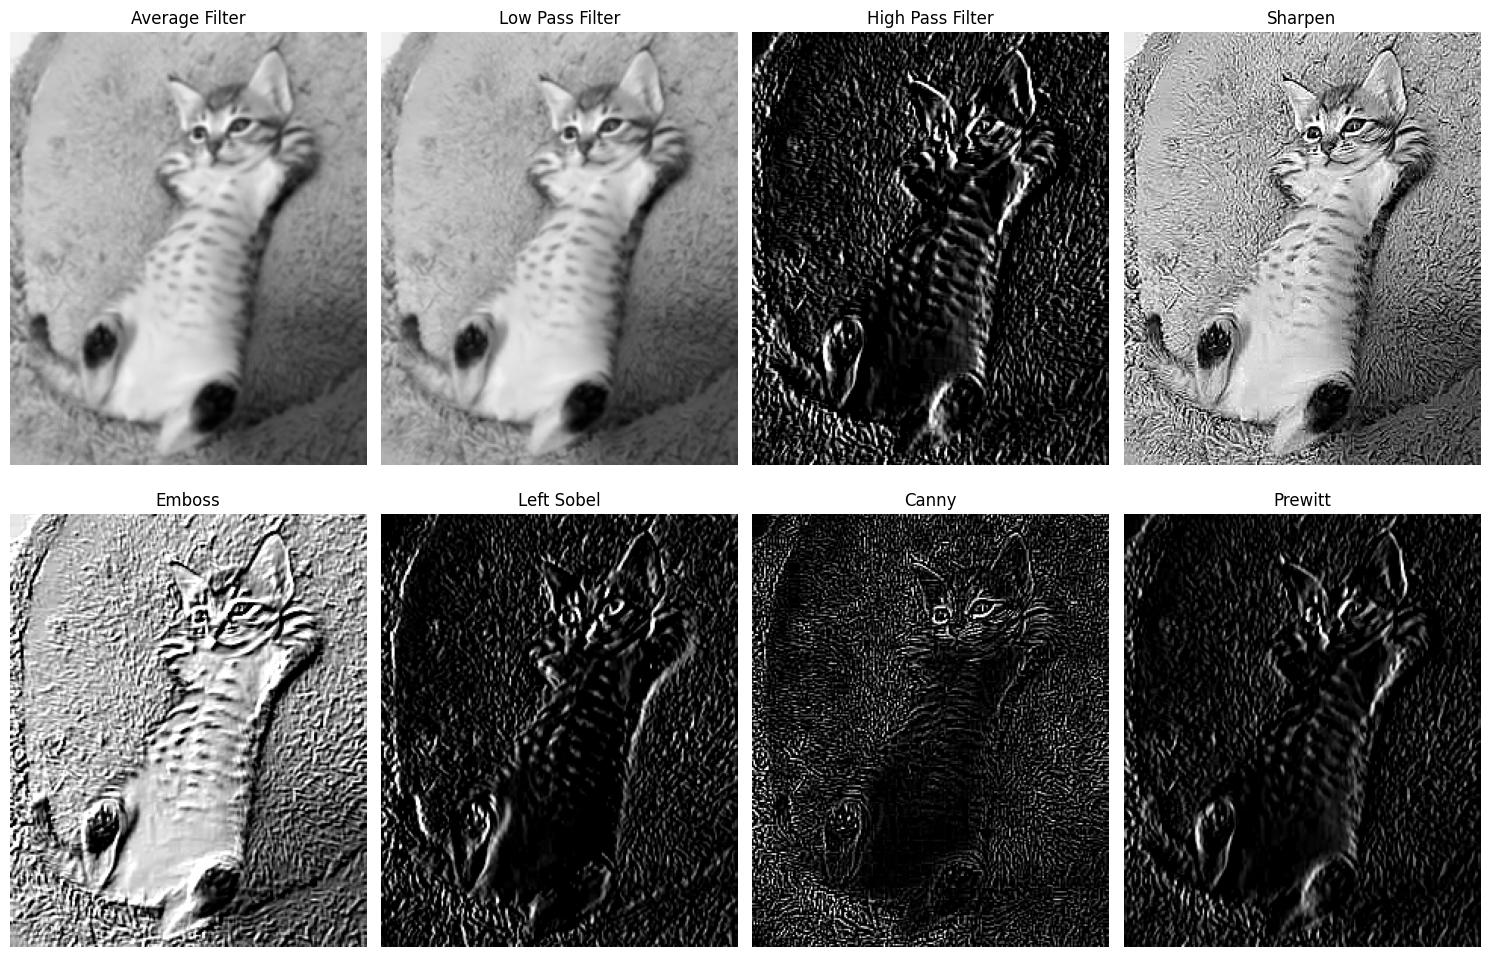

In [15]:
# Cell 6 — Terapkan Masing-Masing Filter (jalan lagi setelah perbaikan di atas)
results = {}
for name, kernel in kernels.items():
    filtered = manual_convolution(img_gray, kernel)  # padding='same' by default
    results[name] = filtered

plt.figure(figsize=(15,10))
for i, (name, img) in enumerate(results.items(), 1):
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()


#Cell 7 – Gaussian Blur 5×5 dan 21×21

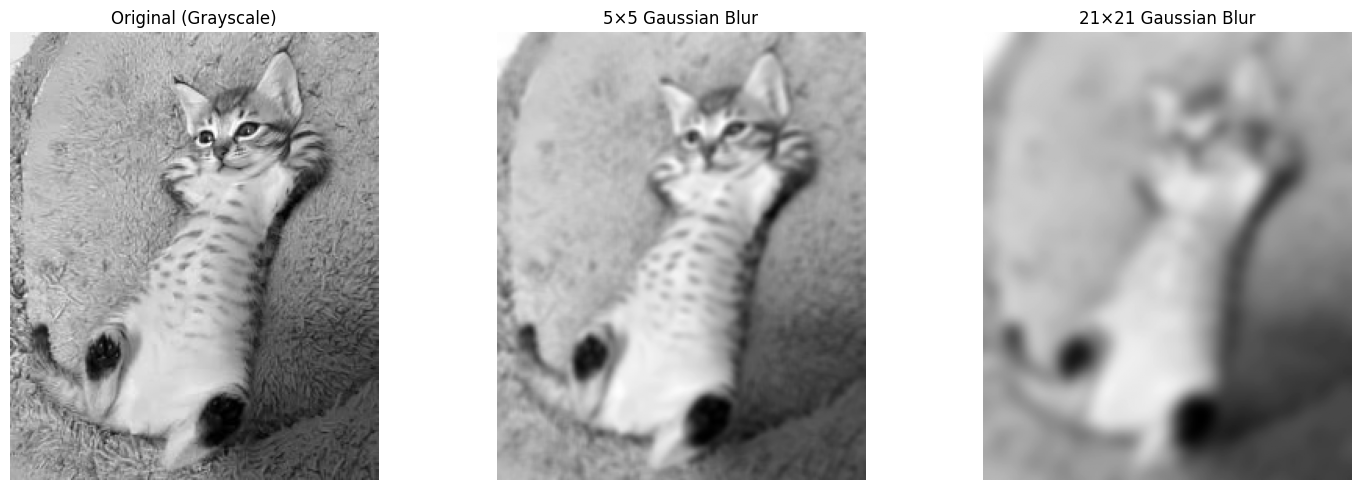

In [16]:
# Cell 7 — Gaussian Blur 5×5 dan 21×21 (pakai padding='same')
import math

def gaussian_kernel(size):
    sigma = math.sqrt(size)
    gk = cv2.getGaussianKernel(size, sigma)
    return gk @ gk.T  # outer product untuk kernel 2D

# Buat kernel Gaussian
g5 = gaussian_kernel(5)
g21 = gaussian_kernel(21)

# Terapkan filter Gaussian dengan padding 'same'
blur5  = manual_convolution(img_gray, g5,  padding='same')
blur21 = manual_convolution(img_gray, g21, padding='same')

# Tampilkan hasil perbandingan
show_side_by_side(
    [img_gray, blur5, blur21],
    ["Original (Grayscale)", "5×5 Gaussian Blur", "21×21 Gaussian Blur"],
    cmap='gray'
)


#Kesimpulan

Praktikum ini memberikan pemahaman bahwa **filter spasial** merupakan teknik dasar untuk memanipulasi piksel citra agar menghasilkan efek tertentu seperti penajaman, penghalusan, atau deteksi tepi.
Melalui proses **konvolusi**, setiap piksel dihitung berdasarkan nilai tetangganya dengan bantuan **kernel** yang berbeda-beda.
Filter seperti **average** dan **low pass** membuat citra tampak lebih halus, sedangkan **high pass** dan **sharpen** menonjolkan detail.
Filter **emboss**, **Sobel**, dan **Prewitt** memperjelas arah tepi dan struktur bentuk, sementara **Gaussian blur** menghasilkan perataan yang lebih lembut.
Dari percobaan ini dapat disimpulkan bahwa pemilihan kernel sangat memengaruhi hasil akhir citra dan menjadi dasar penting dalam pengolahan citra tingkat lanjut seperti deteksi objek dan segmentasi.
